# **Open Data Examples** | Recreation facilities and neighborhood access
This notebook will walk you through the following:
* Downloading the City's recreation facility data from Open Data. These are rec centers, playground equipment, etc.
* Downloading the City's census population data
* "Buffering" from these locations, which means to search a certain distance from points on a map
* Summarize population information in those nearby areas

To run this notebook, you will need to install the following packages using `pip`:
1. `arcgis`
2. `cle-data-toolkit`
3. `lib

In [1]:
from arcgis import GIS
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Look for Cleveland's Parks & Recreation System data provided by the City's Office of Capital Projects

# Establish a connection with ArcGIS Online
gis = GIS()

In [3]:
# Look for the exact title of item. Select the first and only result, the Cleveland Parks service
parks_service = gis.content.search("title:Cleveland Parks and Recreation System")[0]
parks_service

<Item title:"Cleveland Parks and Recreation System" type:Feature Layer Collection owner:jrauschenbach_ago>

In [4]:
# Feature services are like servers that broadcast one or more datasets.
# Let's see what information is available in the layers
for idx, lyr in enumerate(parks_service.layers):
    print(idx, lyr.properties['name'])

0 Cleveland Recreation Centers
1 Cleveland Park Amenities
2 Cleveland Recreation Center Outdoor Amenities
3 Cleveland Parks


In [5]:
# Pick the "Cleveland Recreation Centers" feature layer, query, convert to GEOJSON, and read as geopandas GeoDataFrame
rec_centers_layer = parks_service.layers[0]
rec_centers_featureset = rec_centers_layer.query()
rec_centers_geojson = rec_centers_featureset.to_geojson
rec_centers_gdf = gpd.read_file(rec_centers_geojson, driver="GeoJSON", crs="EPSG:3734").set_crs(epsg=3734, allow_override=True)

In [6]:
# Pick the "Park Amenities" feature layer, query, convert to GEOJSON, and read as geopandas GeoDataFrame
amenities_layer = parks_service.layers[1]
amenities_featureset = amenities_layer.query()
amenities_geojson = amenities_featureset.to_geojson
amenities_gdf = gpd.read_file(amenities_geojson, driver="GeoJSON", crs="EPSG:3734").set_crs(epsg=3734, allow_override=True)

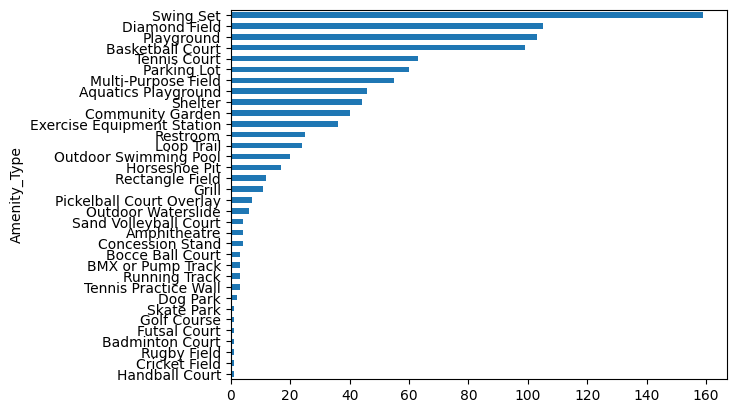

In [7]:
# Let's learn about the most common park amenities in our dataset
ax = amenities_gdf.Amenity_Type.value_counts(ascending=True).plot.barh()

In [8]:
# In order to breakdown access across City population, we will need pouplation data
# Let's use the City's curated version of U.S. Census American Community Survey Estimates
census_ago_id = 'ebeb65deb5c14f4d8849fd68944b7ee6'
census_item = gis.content.get(census_ago_id)

In [9]:
# Lets see what layers this service offers
for idx, lyr in enumerate(census_item.layers):
    print(idx, lyr.properties['name'])

0 Nation
1 State
2 County
3 Census Tract
4 Block Group


In [10]:
city_boundary_item = gis.content.search("title:'City of Cleveland Boundary' owner:clevelandGISAGO")[0]

In [11]:
city_gjson = city_boundary_item.layers[0].query().to_geojson
city_gdf = gpd.read_file(city_gjson, driver="GeoJSON", crs="EPSG:3734").set_crs(epsg=3734, allow_override=True)

In [12]:
blockgroup_census = census_item.layers[4]
# Let's query block groups from the County
blockgroup_fs = blockgroup_census.query(where="County = 'Cuyahoga County'")
blockgroup_gjson = blockgroup_fs.to_geojson
# Read to GeoDataFrame, project to Ohio North so we have clean reliable measurements
census_gdf = gpd.read_file(blockgroup_gjson, driver="GeoJSON", crs="EPSG:3857").set_crs(epsg=3857, allow_override=True).to_crs(epsg=3734)

In [13]:
# Get field aliases
field_map = {}
for fld_dict in blockgroup_census.properties['fields']:
    field_map[fld_dict['name']] = fld_dict['alias']
# Assign to all block groups so we get readable column names
census_gdf = census_gdf.rename(columns=field_map)

In [14]:
field_map

{'OBJECTID': 'Object ID',
 'GEOID': 'Geographic Identifier',
 'ALAND': 'Area of Land (Square Meters)',
 'AWATER': 'Area of Water (Square Meters)',
 'INTPTLAT': 'Current latitude of the internal point',
 'INTPTLON': 'Current longitude of the internal point',
 'NAME': 'Name',
 'State': 'State',
 'County': 'County',
 'P0010001': 'Total Population',
 'H0010001': 'Total Housing Units',
 'H0030002': 'Total Households (Occupied Housing Units)',
 'P001_calc_pctPopDensity': 'Population Density (people per square kilometer)',
 'P0020002': 'Urban population',
 'P0020003': 'Rural population',
 'P0020004': 'Population for whom urban and rural is not defined',
 'P002_calc_pct0002': 'Percent of population that is urban',
 'P002_calc_pct0003': 'Percent of population that is rural',
 'P0030002': 'Population who is White alone',
 'P0030003': 'Population who is Black or African American alone',
 'P0030004': 'Population who is American Indian and Alaska Native alone',
 'P0030005': 'Population who is Asian

In [15]:
# Subset of Cuyahoga County block groups that have representative points spatially within the City polygon
# Representative points are guaranteed to be inside the block groups. Centroids can technically fall outside for doughnut shapes, e.g. near the airport
cle_bgs = census_gdf[census_gdf.geometry.representative_point().intersects(city_gdf.geometry.iloc[0])].copy()

<Axes: >

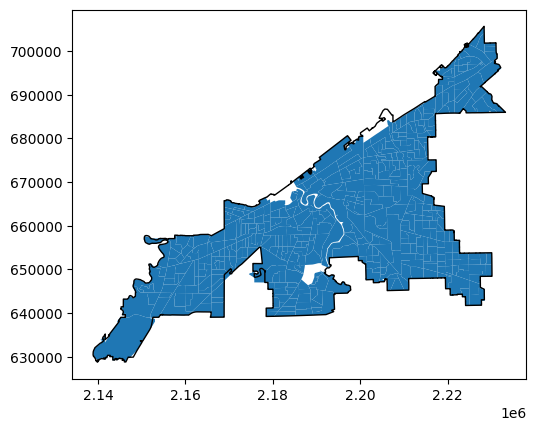

In [16]:
# Let's check how we did. The blue block groups should all be inside our city Boundary
fig, ax = plt.subplots()
cle_bgs.plot(ax=ax)
city_gdf.plot(ax=ax, facecolor='none', edgecolor='black')

In [34]:
# Our primary spatial function, which checks whether a type of amenity is within our buffer distance
# It creates a new column in the given dataframe with a Series of boolean values.
# True = the block group's center is within range, False = the block groups' center is not within range

buffer_distance = 2640 # Half mile in feet
def access_evaluator(access_name, pop_gdf, points_gdf):
    buffer_amenity = points_gdf[points_gdf.Amenity_Type == access_name].buffer(2640).unary_union
    pop_gdf[access_name+"_flag"] = buffer_amenity.intersects(pop_gdf.geometry.representative_point())

In [35]:
# Evaluate each amenity using the function above
for amenity in amenities_gdf.Amenity_Type.unique():
    access_evaluator(amenity, cle_bgs, amenities_gdf)

In [58]:
# Exploring our distribution of flags by each amenity type.
n= 12
top_n = amenities_gdf.Amenity_Type.value_counts(ascending=False).index.to_list()[:n]

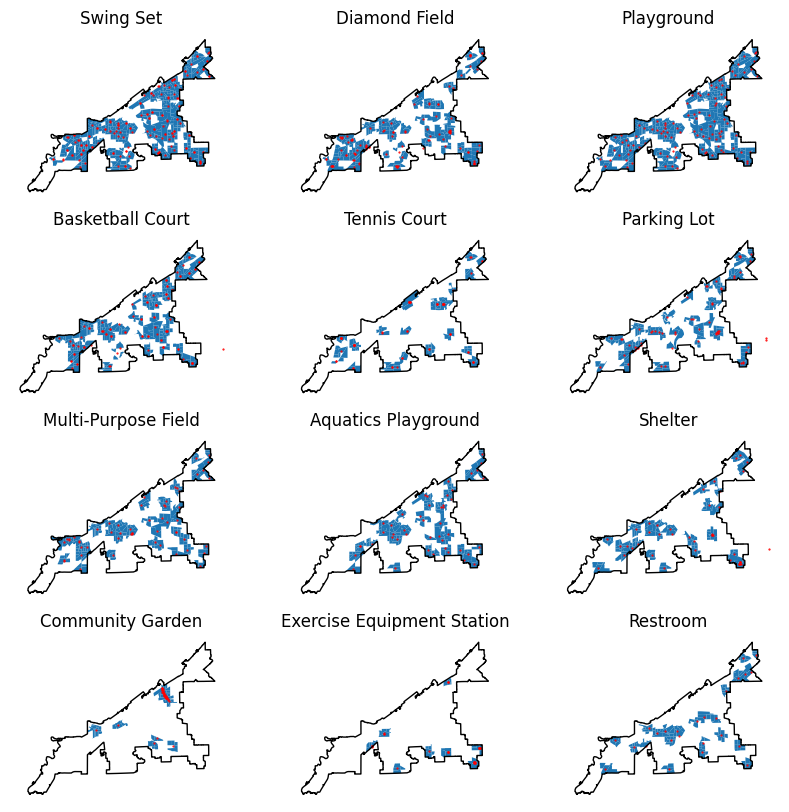

In [67]:
cols, rows = 3,4  #num of subplots <= (cols x rows)
# Create matplotlib figure with an array of axes to plot on
fig, axs = plt.subplots(nrows=rows, ncols=cols)
# Make it larger so we can fit more map
fig.set_size_inches(10,10)

# Iterate through our most frequent amenities 
count = 0
for irow in range(axs.shape[0]):
    for icol in range(axs.shape[1]):
            amenity = top_n[count]
            cle_bgs[ cle_bgs[amenity+"_flag"] == True].plot(ax=axs[irow][icol])
            amenities_gdf[amenities_gdf.Amenity_Type ==  amenity].plot(ax=axs[irow][icol], color='red', markersize=.3)
            city_gdf.plot(ax=axs[irow][icol], facecolor='none', edgecolor='black')
            axs[irow][icol].set_title(amenity)
            axs[irow][icol].set_axis_off()
            count += 1

In [68]:
# Let's use these true/false flags to produce summary statistics
# We want to learn about what percent of different populations are within range of these amenities
# To do this we will need to transform our dataset using groupby and aggregations

# Define the list of Census fields we want to iterate through
demographic_groups = ['Population under 18 years']

# Set up a loop that will perform calculations for each column above
out_list = []
for amenity in amenities_gdf.Amenity_Type.unique(): # For each unique amenity
    report_outs = []
    for fld in demographic_groups: # For each demographic group we listed
        try:
            # Sum the number of people in that group that have value True for access to that amenity
            number_covered =cle_bgs.groupby(f'{amenity}_flag').agg({fld:'sum'}).loc[True].iloc[0] 
            # Sum total number of people in that group
            total_possible = cle_bgs[fld].sum()
            # Divide with access over total number
            percent_covered = (100 * number_covered) / total_possible
        except:
            # If there is not True index, that means nobody has access, return 0
            percent_covered = 0
        # Append these figures to the array for this amenity
        report_outs.append(percent_covered)
    # Append this amenity + report outs to the outbound list
    out_list.append([amenity, *report_outs])

# Create a dataframe from the results
# Add % within 1/2 mile to each group column
access_summary = pd.DataFrame(out_list, columns=['Amenity', *[grp + " % within 1/2 mile" for grp in demographic_groups]])

In [69]:
access_summary

,Amenity,Population under 18 years % within 1/2 mile
0,Basketball Court,52.391285
1,Community Garden,9.916340
2,Diamond Field,50.824689
3,Multi-Purpose Field,45.705972
4,Rectangle Field,12.284421
5,Cricket Field,0.648463
6,Outdoor Swimming Pool,25.624945
7,Parking Lot,38.576643
8,Rugby Field,0.919387
9,Shelter,32.637626


Text(0.5, 1.0, 'Proximity to City Park Amenities using Open Data')

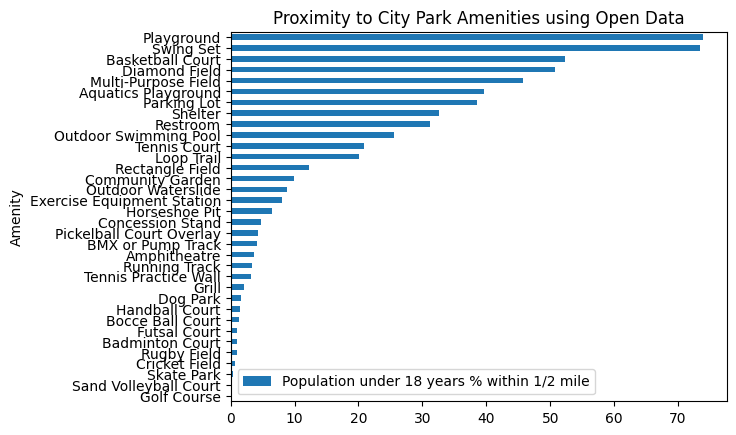

In [70]:
access_summary.set_index('Amenity').sort_values('Population under 18 years % within 1/2 mile').plot.barh()
plt.title('Proximity to City Park Amenities using Open Data')

### We now better understand access for Cleveland's under 18 population across all park amenities from the Open Data layer.  

Some amenities are essential and need to be nearer for access; others are occasional visits that can be further. Let's set a goal for 100% coverage of playgrounds within 1/2 mile of all minors in Cleveland.

**If we had to pick only 1 location, how can we use the data to make the most impactful change?**

In [21]:
# First we need to obtain information about contiguity of each group
from libpysal.weights import Queen, Rook, KNN

In [79]:
# Block gruops that don't have access to playground now. These are candidates for assessing optimal location
candidate_bgs = cle_bgs[cle_bgs['Playground_flag'] == False]

# The Rook contiguity tells us for each tract that doesn't have access now, what other no access tracts share an edge
w_rook = Rook.from_dataframe(candidate_bgs)

/tmp/ipykernel_1346/1339868487.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_rook = Rook.from_dataframe(candidate_bgs)
/home/dns/.pyenv/versions/3.10.12/envs/uai_env/lib/python3.10/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 26 disconnected components.
 There are 12 islands with ids: 0, 27, 28, 48, 52, 57, 58, 92, 98, 102, 103, 105.
  W.__init__(self, neighbors, ids=ids, **kw)


In [91]:
population_dict = {}
for bg in w_rook.neighbors.items():
    cluster_pop = candidate_bgs.iloc[bg[1]]['Population under 18 years'].sum()
    population_dict[bg[0]] = cluster_pop

In [99]:
max_idx = max(population_dict, key=population_dict.get)

TypeError: 'MultiPolygon' object is not callable

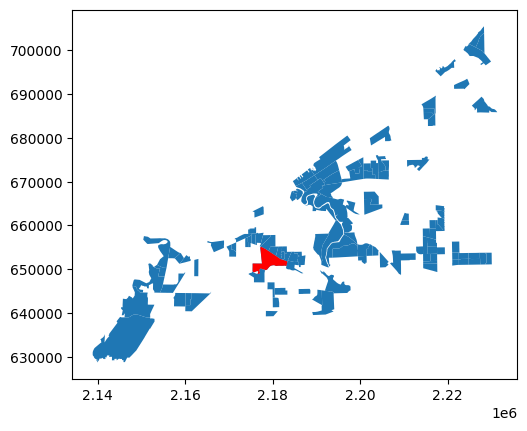

In [110]:
ax = candidate_bgs.plot()
candidate_bgs.iloc[[max_idx]].plot(ax=ax, facecolor='red')
candidate_bgs.iloc[w_rook.neighbors[max_idx]].plot(ax=ax, facecolor='none', edgecolor='green')
city_gdf.plot(ax=ax, edgecolor='black', facecolor='none')